In [37]:
### TODO: DELETE THIS NOTEBOOK BEFORE SUBMISSION
### IT USES PANDAS WHICH WE'RE NOT ALLOWED TO RELY ON AFTER SUBMISSION

import json
import pandas as pd  

# load JSON logs
with open("logs/pretraining.json") as f:
    data = json.load(f)

# flatten into list of rows
rows = []
for run_name, epochs in data.items():
    for epoch_str, metrics in epochs.items():
        epoch = int(epoch_str)
        row = {"run_name": run_name, "epoch": epoch}
        row.update(metrics)
        rows.append(row)

df = pd.DataFrame(rows)
df

,run_name,epoch,train_loss,train_ClassifierHead(2)_loss,train_ClassifierHead(2)_Acc,val_loss,val_ClassifierHead(2)_loss,val_ClassifierHead(2)_Acc,train_ClassifierHead(37)_loss,train_ClassifierHead(37)_Acc,val_ClassifierHead(37)_loss,val_ClassifierHead(37)_Acc,train_BboxHead_loss,train_BboxHead_IoU,val_BboxHead_loss,val_BboxHead_IoU
0,cnn_species,1,0.610392,0.610392,0.670791,0.591884,0.591884,0.689531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn_species,2,0.589961,0.589961,0.698434,0.586430,0.586430,0.708484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cnn_species,3,0.582057,0.582057,0.706940,0.579895,0.579895,0.705776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cnn_species,4,0.577658,0.577658,0.713319,0.577766,0.577766,0.703069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cnn_species,5,0.571973,0.571973,0.722405,0.578491,0.578491,0.711191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,res_species_breed_bbox_101,16,2.980323,0.313315,1.000000,3.104190,0.314442,0.999097,2.663171,0.974870,2.706618,0.909747,0.003837,0.811542,0.083129,0.365937
556,res_species_breed_bbox_101,17,2.984249,0.313484,1.000000,3.124078,0.315154,0.998195,2.666342,0.956505,2.725172,0.871841,0.004424,0.801490,0.083752,0.412779
557,res_species_breed_bbox_101,18,3.005216,0.315859,0.997487,3.151510,0.323407,0.988267,2.678745,0.937174,2.742979,0.825812,0.010612,0.728161,0.085124,0.334706
558,res_species_breed_bbox_101,19,3.018622,0.316467,0.997100,3.140236,0.317496,0.994585,2.683418,0.930988,2.738145,0.852888,0.018737,0.661039,0.084594,0.345992


In [60]:
import re

def extract_arch_task(name):
    # try matching optional prefix and suffix
    m = re.match(r"^([a-z]+)(?:_)?([a-z]+(?:_[a-z]+)*?)(?:_(\d+|[a-z]+))?$", name)
    if not m:
        return None, None
    prefix, mid, suffix = m.groups()
    if suffix and (suffix.isdigit()):
        arch = f"{prefix}{suffix}"
        task = mid
    else:
        arch = prefix
        task = mid + (f"_{suffix}" if suffix else "")
    return arch, task

df[["arch", "task"]] = df["run_name"].apply(lambda name: pd.Series(extract_arch_task(name)))

In [61]:
df[["arch", "task"]] = df["run_name"].apply(lambda name: pd.Series(extract_arch_task(name)))

task_replacements = {
    'breed_species': 'species_breed'
}

# Apply task replacements
df['task'] = df['task'].replace(task_replacements)

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

def best_epochs_by_metric(df: pd.DataFrame, target_metric: str) -> pd.DataFrame:
    return (
        df.loc[df.groupby("run_name")[target_metric].idxmin()]
        .reset_index(drop=True)
        .sort_values(target_metric, ascending=False)
    )

def visualize_task_performance(best_epochs_df: pd.DataFrame, task_name: str, eval_metrics: list[str]):
    # filter for matching task_name
    df = best_epochs_df[best_epochs_df['task'] == task_name]

    if df.empty:
        print(f"no runs found for task '{task_name}'")
        return

    # set up bar chart
    x_labels = df['arch'].astype(str)  
    x = range(len(x_labels))
    width = 0.8 / len(eval_metrics)  # divide bar width over metrics

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, metric in enumerate(eval_metrics):
        if metric not in df.columns:
            print(f"warning: metric '{metric}' not in dataframe")
            continue
        offsets = [xi + i * width for xi in x]
        ax.bar(offsets, df[metric], width=width, label=metric)

    ax.set_xticks([xi + width * (len(eval_metrics) - 1) / 2 for xi in x])
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.set_ylabel("metric value")
    ax.set_title(f"Task performance for '{task_name}'")
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



In [64]:
best_of

,run_name,epoch,train_loss,train_ClassifierHead(2)_loss,train_ClassifierHead(2)_Acc,val_loss,val_ClassifierHead(2)_loss,val_ClassifierHead(2)_Acc,train_ClassifierHead(37)_loss,train_ClassifierHead(37)_Acc,val_ClassifierHead(37)_loss,val_ClassifierHead(37)_Acc,train_BboxHead_loss,train_BboxHead_IoU,val_BboxHead_loss,val_BboxHead_IoU,arch,task
6,cnn_species_breed_bbox,18,3.790775,0.509867,0.797796,3.842156,0.521061,0.779783,3.207823,0.289001,3.247536,0.238267,0.073085,0.164522,0.073560,0.202445,cnn,species_breed_bbox
3,cnn_breed_species,19,3.663972,0.483614,0.831432,3.729455,0.497732,0.813177,3.180357,0.316064,3.231724,0.236462,NaN,NaN,NaN,NaN,cnn,species_breed
2,cnn_breed_bbox,19,3.248669,NaN,NaN,3.298736,NaN,NaN,3.175806,0.307558,3.224552,0.248195,0.072863,0.166146,0.074184,0.205941,cnn,breed_bbox
1,cnn_breed,20,3.169412,NaN,NaN,3.238008,NaN,NaN,3.169412,0.306399,3.238008,0.237365,NaN,NaN,NaN,NaN,cnn,breed
26,res_species_breed_bbox_18,13,2.975061,0.313527,1.000000,3.144469,0.317533,0.997292,2.657932,1.000000,2.753029,0.924188,0.003602,0.818145,0.073906,0.358772,res18,species_breed_bbox
27,res_species_breed_bbox_50,2,3.105002,0.317814,0.996907,3.106968,0.316935,0.998195,2.719197,0.894065,2.718859,0.875451,0.067991,0.240112,0.071174,0.221053,res50,species_breed_bbox
25,res_species_breed_bbox_101,3,3.070076,0.315522,0.998260,3.098187,0.315411,0.999097,2.695245,0.905084,2.713798,0.876354,0.059309,0.318685,0.068979,0.246775,res101,species_breed_bbox
17,res_breed_species_18,18,2.970238,0.313348,1.000000,3.061401,0.318996,0.993682,2.656890,1.000000,2.742406,0.920578,NaN,NaN,NaN,NaN,res18,species_breed
18,res_breed_species_50,19,2.977005,0.313402,1.000000,3.025718,0.315922,0.996390,2.663604,0.966557,2.709796,0.891697,NaN,NaN,NaN,NaN,res50,species_breed
16,res_breed_species_101,7,2.990462,0.313516,1.000000,3.018640,0.314875,0.999097,2.676946,0.921902,2.703765,0.863718,NaN,NaN,NaN,NaN,res101,species_breed


In [65]:
best_of = best_epochs_by_metric(df, 'val_loss')
metrics = [key for key in best_of.keys() if 'val' in key and 'loss' not in key]

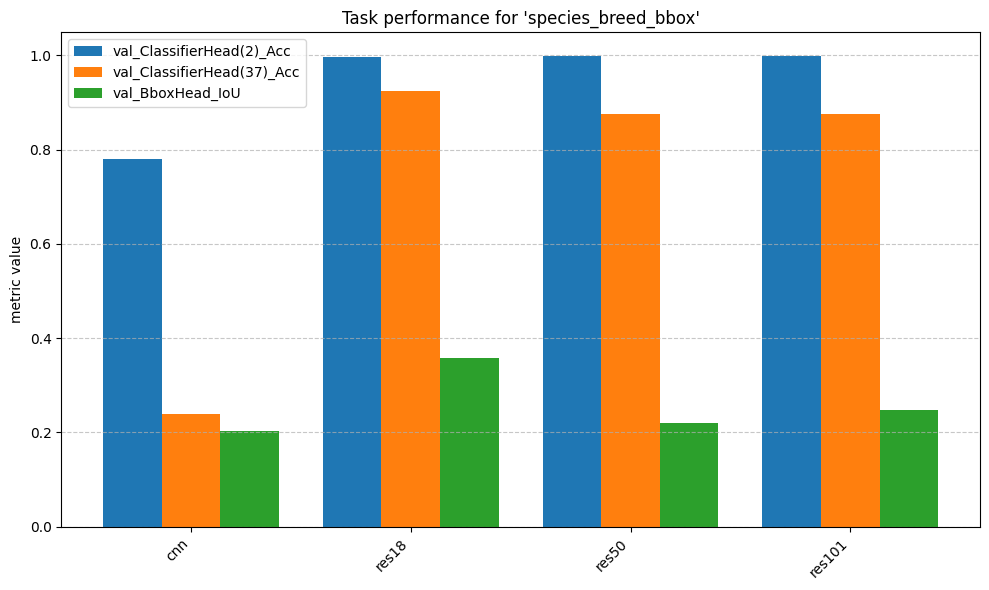

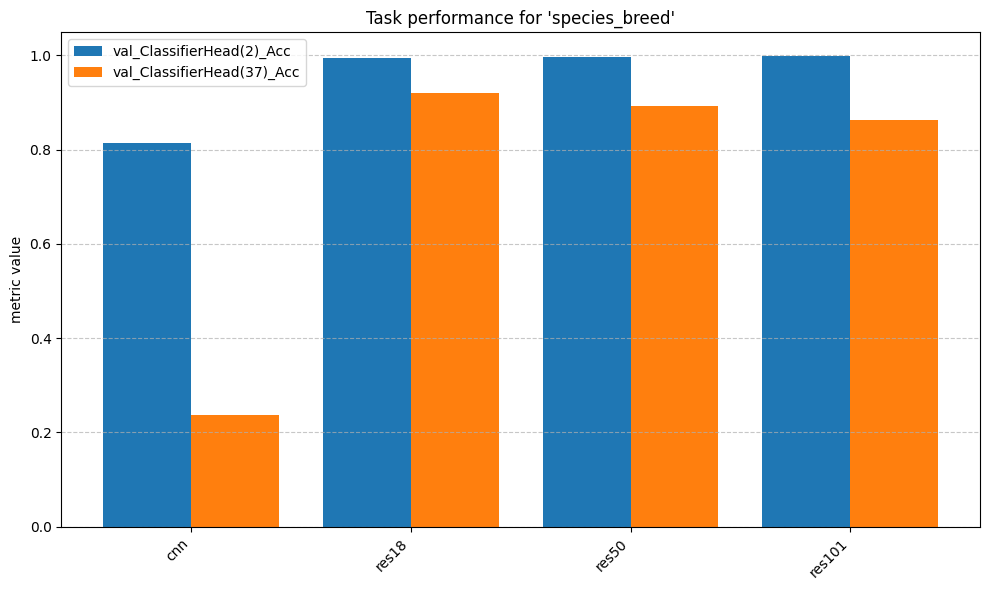

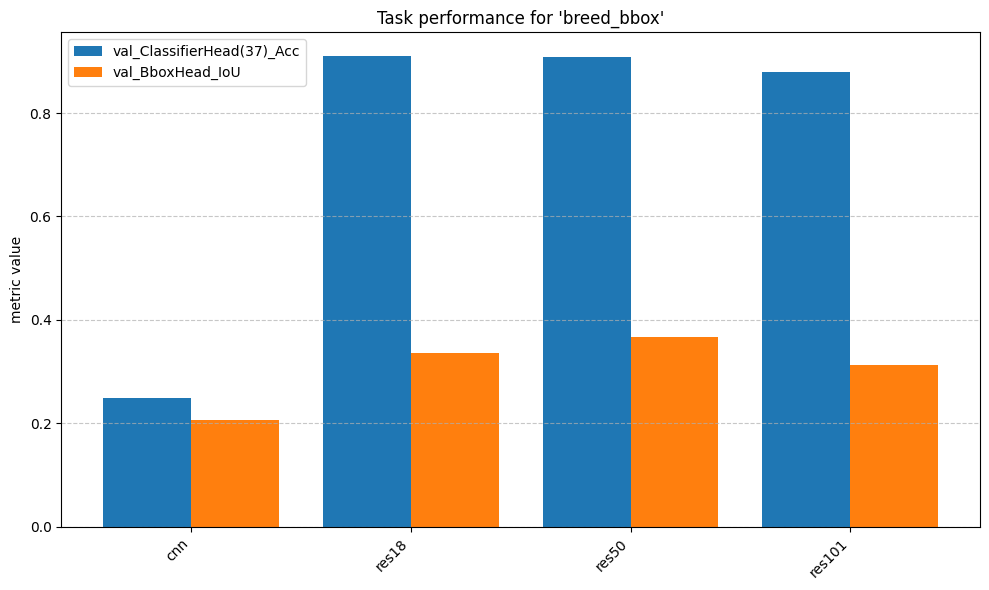

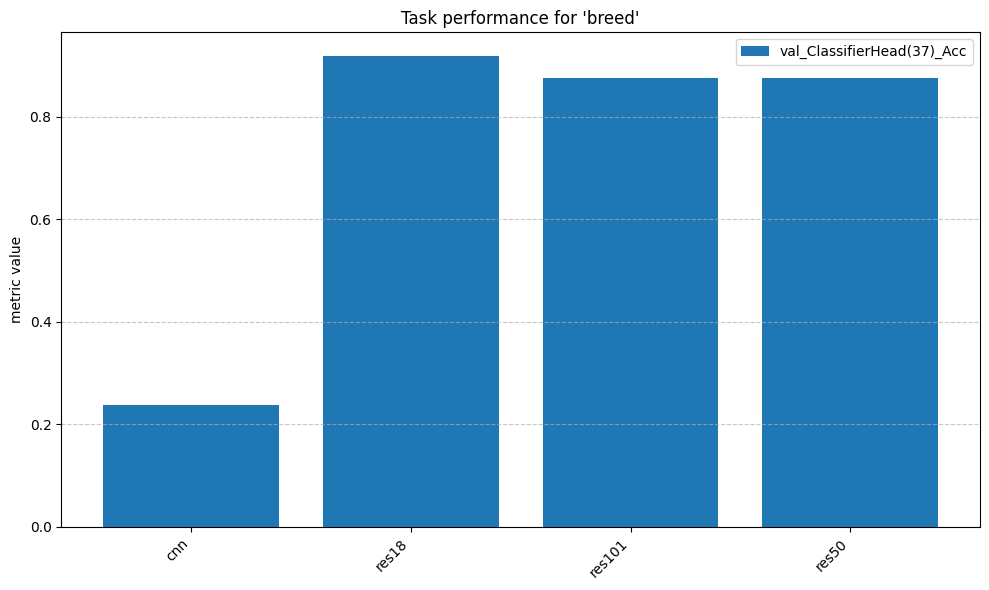

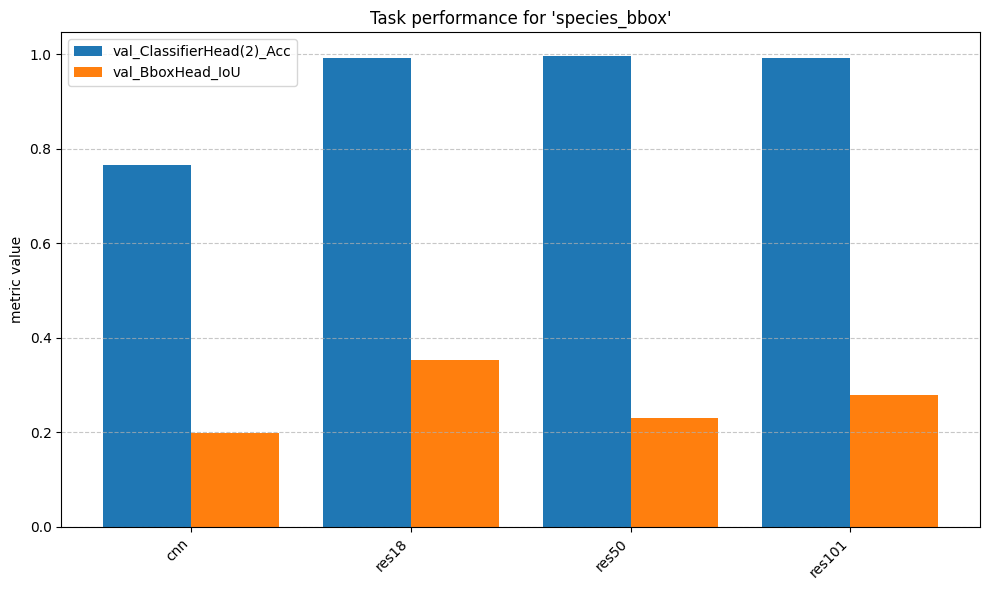

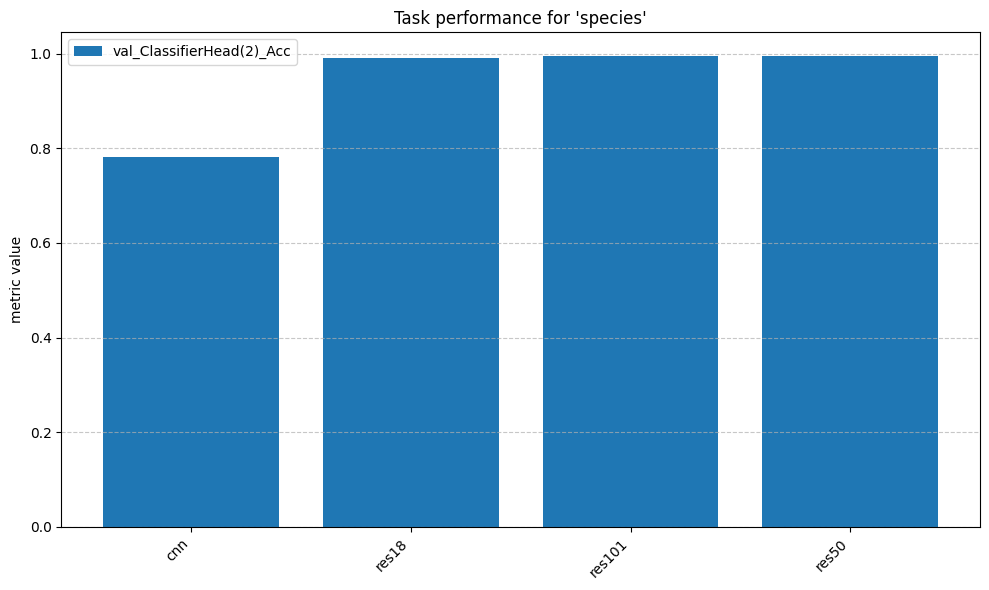

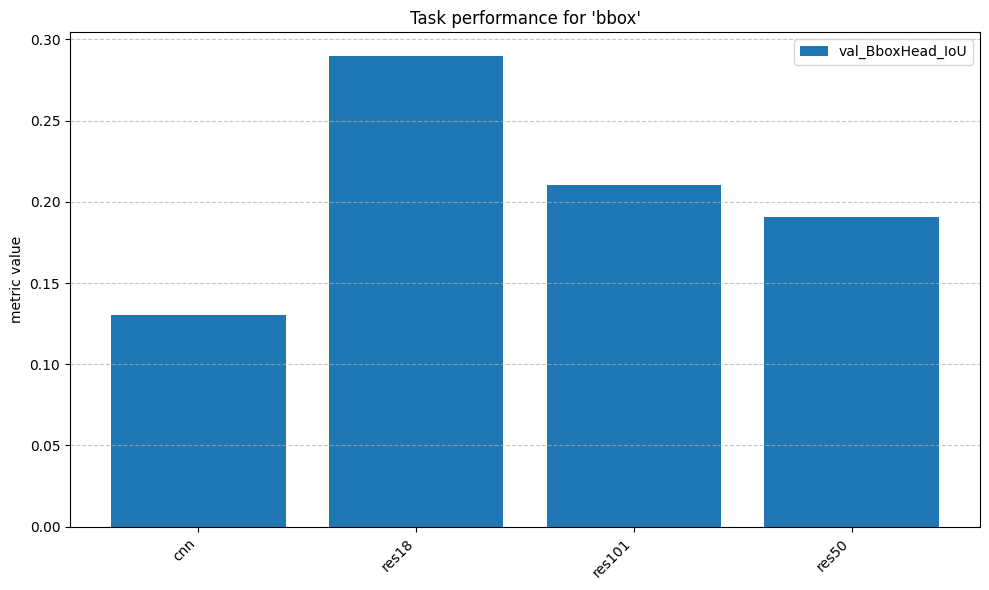

In [66]:
for task in best_of['task'].unique():
    relevant_metrics = [metric for metric in metrics if not any(best_of[best_of['task'] == task][metric].isnull())]
    visualize_task_performance(best_of, task, eval_metrics=relevant_metrics)